In [122]:
from simbad_download import resolve_name
import pandas as pd

from astropy.coordinates import ICRS, SkyCoord
import astropy.units as u

import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from extinction import add_colors_and_abs_mag

from scipy.optimize import minimize

In [59]:
%matplotlib notebook  

In [2]:
KAPPA = 4.74047

In [3]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name('NGC 188')

In [4]:
sources = pd.read_csv('./ngc 188 5d.csv')

In [5]:
len(sources)

301561

In [6]:
sources.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error
0,575922816240170368,42.067044,0.718274,87.526657,0.631198,0.440745,0.724745,0.608138,-1.037192,0.951654,3.024045,0.948973
1,575921205628441344,39.110251,0.033311,87.436855,0.027938,0.711382,0.031558,22.542192,2.641619,0.045092,4.007487,0.039009
2,575921308706406400,39.462327,0.567571,87.449999,0.471968,0.631252,0.562629,1.121969,3.403206,0.823528,1.344071,0.753207
3,575921476210326272,40.225136,0.087846,87.459656,0.073540,0.428389,0.094495,4.533451,0.542979,0.143017,6.791917,0.120112
4,575921510570062336,40.025703,0.118615,87.461371,0.101676,0.576776,0.118824,4.854045,0.713331,0.170573,6.121507,0.156338


In [7]:
sky_coords = SkyCoord(ra=sources['ra'].values,
                      dec=sources['dec'].values,
                      unit=(u.deg, u.deg),
                      frame=ICRS)

sources.ra = sky_coords.ra.wrap_at(180 * u.deg).value

In [8]:
coordinates = SkyCoord(ra=sources.ra.values*u.deg, dec=sources.dec.values*u.deg, 
                       distance=(1/sources.parallax.values)*u.kpc, radial_velocity=cp_radvel*u.km/u.s,
                       pm_ra_cosdec=sources.pmra.values*u.mas/u.yr, pm_dec=sources.pmdec.values*u.mas/u.yr,
                       frame=ICRS)

The perpendicular and parallel motions $\mu_\parallel$ and $\mu_\perp$ are defined as:

$\begin{bmatrix}
\mu_\parallel \\
\mu_\perp
\end{bmatrix} = 
\begin{bmatrix}
\rm sin\theta & \rm cos\theta \\
-\rm cos\theta & \rm sin\theta \\
\end{bmatrix}
\begin{bmatrix}
\mu_{\alpha*} \\
\mu_\delta
\end{bmatrix}$

where $\theta$ is defined as:

$\rm tan\theta = \frac{\rm sin(\alpha_{\rm cp}-\alpha)}{\rm cos\delta\rm tan\delta_{\rm cp}-\rm sin\delta\rm cos(\alpha_{\rm cp}-\alpha)}$

The coordinates of the convergent point $(\alpha_{\rm cp}, \delta_{\rm cp})$ can be set to the cluster center.

Since we want $\mu_\perp=0$, we can define $\mathrm{tan}\theta$ as:

$\rm{tan}\theta=\frac{\mu_{\alpha*,cp}}{\mu_{\delta,cp}}$

So we work in:

$
\begin{bmatrix}
v_\parallel \\
v_\perp
\end{bmatrix}=
\begin{bmatrix}
\frac{\mu_\parallel}{\pi}-\frac{\mu_{\delta,cp}}{\pi_c} \\
\frac{\mu_\perp}{\pi}
\end{bmatrix}
$

In [9]:
galactic_cartesian = coordinates.galactic.cartesian

In [10]:
def cp_proper_motions(ra: np.float32, 
                      dec: np.float32,
                      par: np.float32,
                      pmra: np.float32,
                      pmdec: np.float32) -> np.matrix:
    
    tan_theta = cp_pmra/cp_pmdec
    
    sin_theta = tan_theta/np.sqrt(1+np.power(tan_theta, 2))
    cos_theta = 1/np.sqrt(1+np.power(tan_theta, 2))
    mu_values = np.squeeze(np.asarray(np.matmul(
                np.matrix([[sin_theta, cos_theta],
                           [-cos_theta, sin_theta]]),
                np.matrix([pmra, pmdec]).T)))
    return mu_values/par-np.array([cp_pmra/cp_par, 0.])

In [11]:
matrices = np.vectorize(cp_proper_motions, otypes=[np.ndarray])

In [12]:
cp_proper_motions(cp_ra+.0001, cp_dec+.0001, cp_par, cp_pmra, cp_pmdec)

array([-3.76602784e-01, -2.19715619e-16])

In [13]:
proper_motions = np.stack(matrices(sources.ra.values, sources.dec.values, sources.parallax.values,
         sources.pmra.values, sources.pmdec.values))

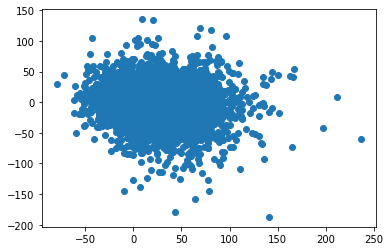

In [14]:
plt.scatter(proper_motions[:, 0], proper_motions[:, 1])

In [15]:
cluster_values = pd.DataFrame(data=np.array([
    galactic_cartesian.x.value,
    galactic_cartesian.y.value,
    galactic_cartesian.z.value,
    proper_motions[:, 0],
    proper_motions[:, 1]
]).T, columns=['x', 'y', 'z', 'u_par', 'u_per'])

In [16]:
from scipy import stats

In [17]:
cluster_values.describe()

,x,y,z,u_par,u_per
count,301561.000000,301561.000000,301561.000000,301561.000000,301561.000000
mean,-1.143834,1.772945,0.839831,4.865873,1.969290
std,0.363206,0.549702,0.270168,9.311390,7.893219
min,-2.292589,0.961483,0.399264,-79.365328,-187.379645
25%,-1.384274,1.315781,0.625048,-0.123497,-1.561240
50%,-1.065109,1.652953,0.781458,4.114580,2.060941
75%,-0.846609,2.144768,1.011263,8.697442,5.809466
max,-0.568047,3.304153,1.824493,236.722444,135.409641


In [18]:
#cluster_values_q = cluster_values[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1)]

In [19]:
#sources_q = sources[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1).values]

In [20]:
scaler = StandardScaler()

s = scaler.fit_transform(cluster_values.values)

In [21]:
len(s)

301561

In [22]:
import matplotlib.pyplot as plt

bleh

In [23]:
from sklearn.cluster import DBSCAN

In [24]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


In [65]:
def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

In [66]:
is_in_edr3 = is_in_cluster_function(sources)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [67]:
def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

In [80]:
dbscan_clust = DBSCAN(eps=.135, min_samples=50)
dbscan_fit = dbscan_clust.fit(s)

dbscan_labels = dbscan_fit.labels_
unique_labels = set(dbscan_labels)
print(f'Classified into {len(unique_labels)} labels: {unique_labels}')

print(dbscan_labels.shape)

sources['labels'] = dbscan_labels

Classified into 9 labels: {0, 1, 2, 3, 4, 5, 6, 7, -1}
(301561,)


In [81]:
sources['labels'].value_counts()

-1    298236
 3      1562
 0      1409
 7        82
 6        76
 2        57
 4        50
 1        46
 5        43
Name: labels, dtype: int64

In [83]:
in_cluster = check_for_cluster_children(from_lit_edr3, sources[sources['labels']==3])

1050/1327 objects found in the cluster.


<IPython.core.display.Javascript object>


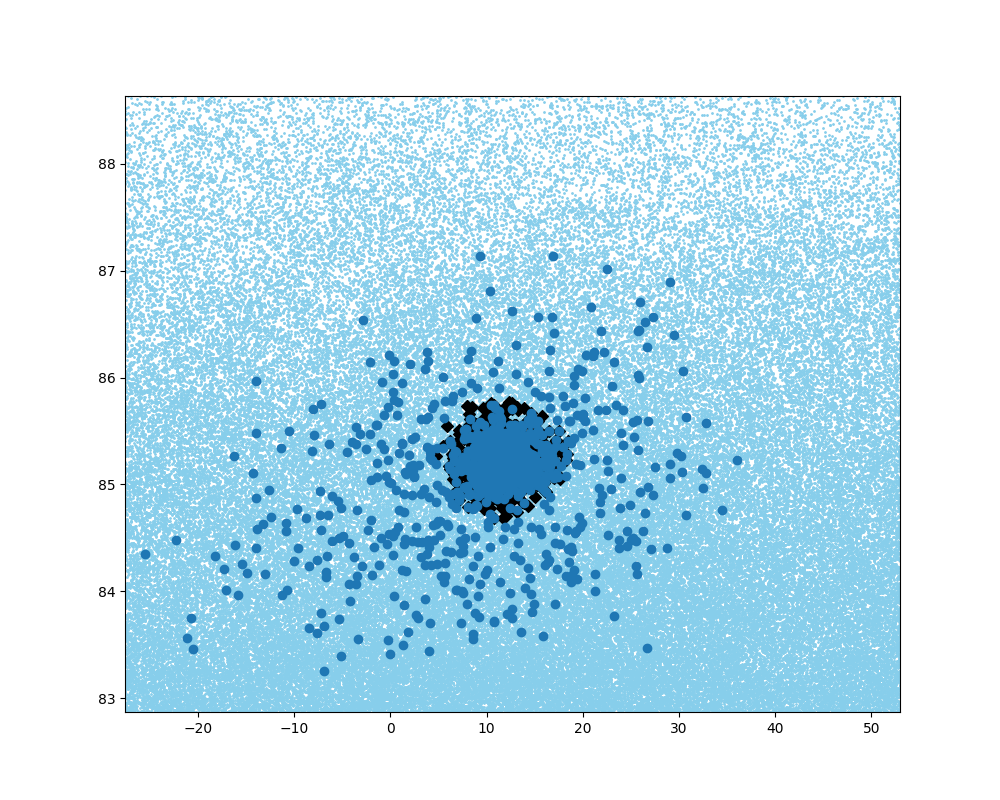

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(sources.ra, sources.dec, s=1, color='skyblue')
plt.scatter(from_lit_edr3.ra, from_lit_edr3.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
for ul in [3]:
    plt.scatter(sources[sources['labels']==ul].ra, sources[sources['labels']==ul].dec, label=ul)
    
# plt.gca().set_ylim(83, 87);
# plt.gca().set_xlim(-20, 50);
    

In [97]:
missed = from_lit_edr3[~in_cluster]
found = from_lit_edr3[in_cluster]

In [109]:
missed.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
17,Cl* NGC 188 WV 18,303516,2004PASP..116.1012S,11.450357,85.162006,2020yCat.1350....0G,0.4293,0.0590,2020yCat.1350....0G,-2.306,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935040952906240|TIC 461601099|2MA...,573935040952906240,5.739350e+17,461601099.0,2
29,Cl* NGC 188 MT 93,4924978,2004PASP..116.1012S,11.103153,85.227056,2020yCat.1350....0G,0.3893,0.0699,2020yCat.1350....0G,-2.480,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941809821326848|Cl* NGC 188 ...,573941809821326848,5.739418e+17,NaN,3
60,Cl* NGC 188 PKM 7586,4923112,2020A&A...640A...1C,8.737110,85.049662,2020yCat.1350....0G,0.4291,0.0645,2020yCat.1350....0G,-2.171,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573570204954828800|TIC 461597282|Cl*...,573570204954828800,5.735702e+17,461597282.0,4
65,NGC 188 2211,303928,2004PASP..116.1012S,11.502497,85.195300,2020yCat.1350....0G,0.3987,0.0557,2020yCat.1350....0G,-2.291,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573940985187628800|TIC 461601145|2MA...,573940985187628800,5.739410e+17,461601145.0,6
104,Cl* NGC 188 PKM 9268,4927275,2020A&A...640A...1C,14.165300,85.029411,2020yCat.1350....0G,0.4423,0.0582,2020yCat.1350....0G,-2.339,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573747535563330560|TIC 461620468|Cl*...,573747535563330560,5.737475e+17,461620468.0,4


In [124]:
missed_dr3 = pd.merge(left=missed[['EDR3 id']], right=sources, left_on='EDR3 id', right_on='source_id')

In [143]:
found_dr3 = pd.merge(left=found[['EDR3 id', 'TIC']], right=sources, left_on='EDR3 id', right_on='source_id')

<IPython.core.display.Javascript object>


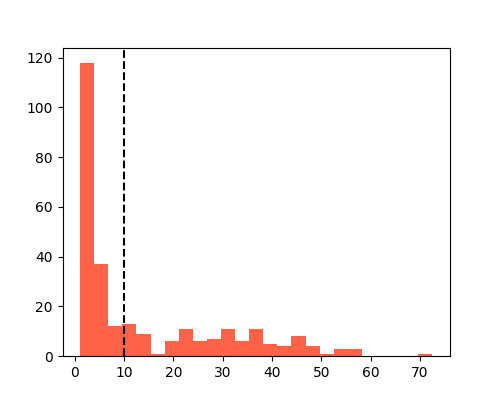

In [125]:
plt.figure(figsize=(5, 4));
plt.hist(missed_dr3.parallax_over_error, bins=25, color='tomato');
plt.axvline(10, color='black', linestyle='--');

In [127]:
correct_par = missed_dr3[missed_dr3['parallax_over_error']>10]

In [128]:
len(correct_par)

109

<IPython.core.display.Javascript object>


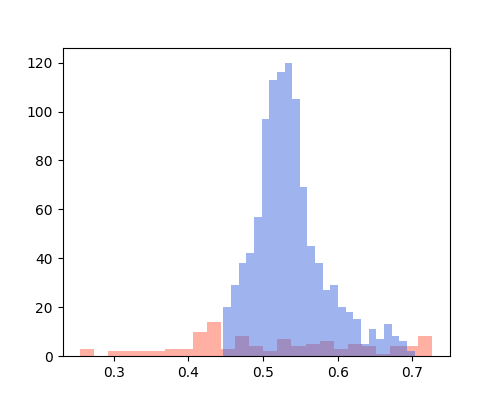

In [131]:
plt.figure(figsize=(5, 4));
plt.hist(correct_par.parallax, bins=25, alpha=.5, color='tomato');
plt.hist(found_dr3.parallax, bins=25, alpha=.5, color='royalblue');

<IPython.core.display.Javascript object>


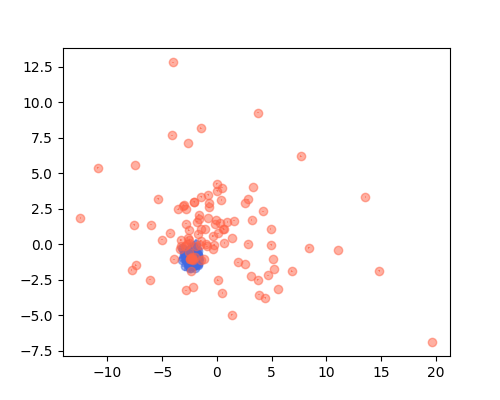

In [138]:
plt.figure(figsize=(5, 4));
plt.errorbar(found_dr3.pmra, found_dr3.pmdec,
             xerr=found_dr3.pmra_error, yerr=found_dr3.pmdec_error,
             color='royalblue', alpha=.5, fmt='o');
plt.errorbar(correct_par.pmra, correct_par.pmdec,
             xerr=correct_par.pmra_error, yerr=correct_par.pmdec_error,
             color='tomato', alpha=.5, fmt='o');

In [140]:
pmra_std = np.std(found_dr3.pmra)
pmdec_std = np.std(found_dr3.pmdec)
pm_correct = missed_dr3[(np.abs(missed_dr3.pmra-cp_pmra)<pmra_std) & (np.abs(missed_dr3.pmdec-cp_pmdec)<pmdec_std)]

In [141]:
len(pm_correct)

57

<IPython.core.display.Javascript object>


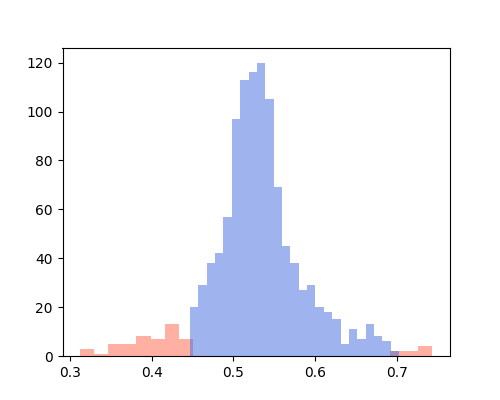

In [142]:
plt.figure(figsize=(5, 4));
plt.hist(pm_correct.parallax, bins=25, alpha=.5, color='tomato');
plt.hist(found_dr3.parallax, bins=25, alpha=.5, color='royalblue');

In [145]:
found_dr3.to_csv('./found_cp_tails.csv', index=None)

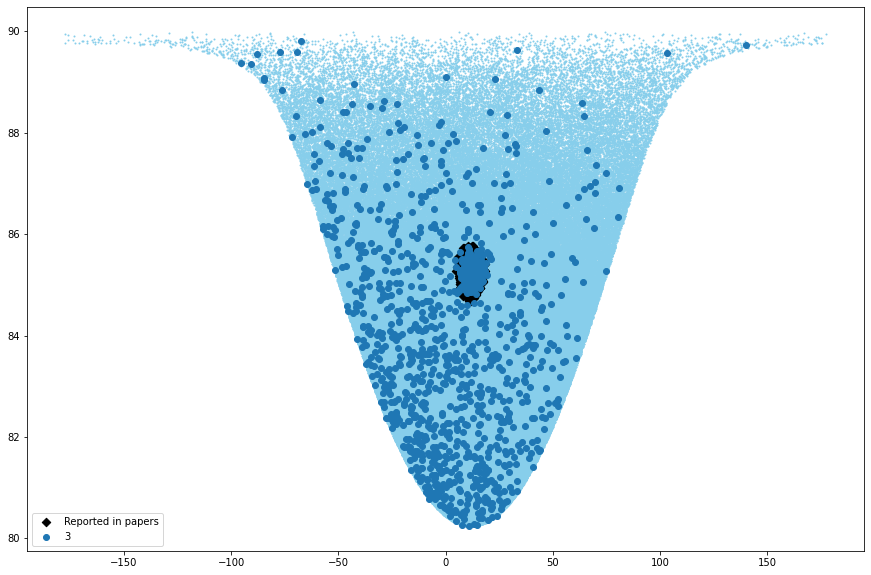

In [37]:
plt.figure(figsize=(15, 10))
plt.scatter(sources.ra, sources.dec, s=1, color='skyblue')
plt.scatter(from_lit_edr3.ra, from_lit_edr3.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
proper_motion_mask = (np.abs(cluster_values.u_par)<.5) & (np.abs(cluster_values.u_per)<.5)
plt.scatter(sources[proper_motion_mask].ra, sources[proper_motion_mask].dec, label=ul)
plt.legend()

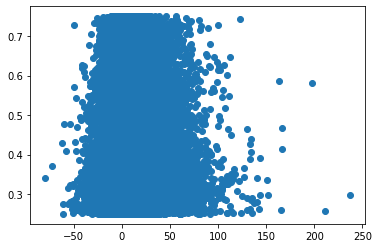

In [161]:
plt.scatter(cluster_values.u_par, sources.parallax)

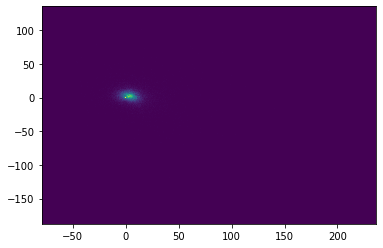

In [159]:
plt.hist2d(cluster_values.u_par, cluster_values.u_per, bins=1000);
# plt.gca().set_xlim(-10, 10)
# plt.gca().set_ylim(-10, 10);

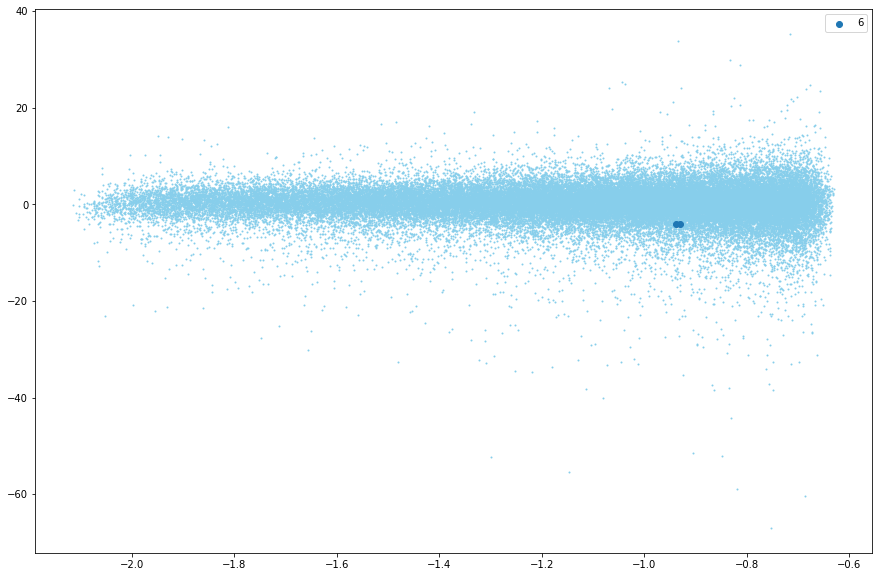

In [1001]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.x, cluster_values.u_per, s=1, color='skyblue')
for ul in [6]:
    plt.scatter(cluster_values[sources['labels']==ul].x, cluster_values[sources['labels']==ul].u_per, label=ul)
plt.legend()
# plt.gca().set_xlim(-20, 20)
# plt.gca().set_ylim(-10, 10)

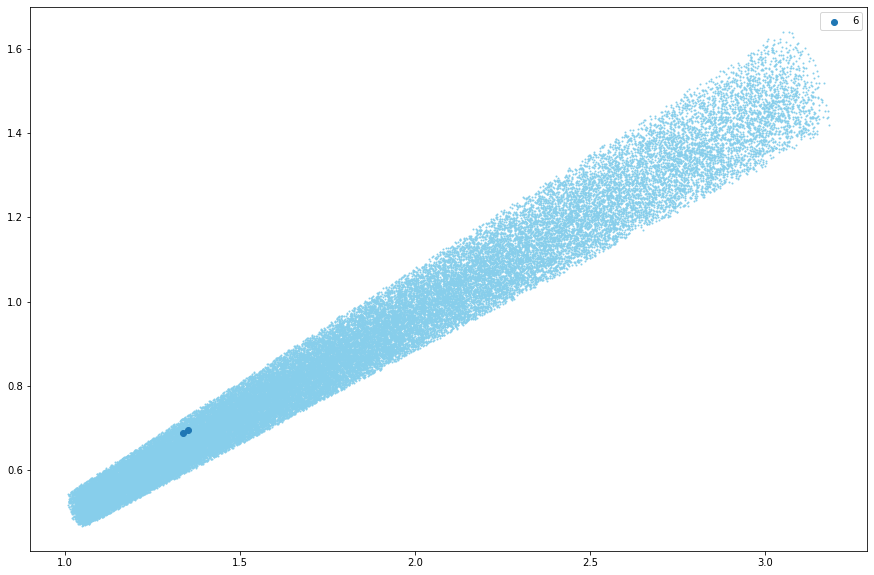

In [1002]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.y, cluster_values.z, s=1, color='skyblue')
for ul in [6]:
    plt.scatter(cluster_values[sources['labels']==ul].y, cluster_values[sources['labels']==ul].z, label=ul)
plt.legend()

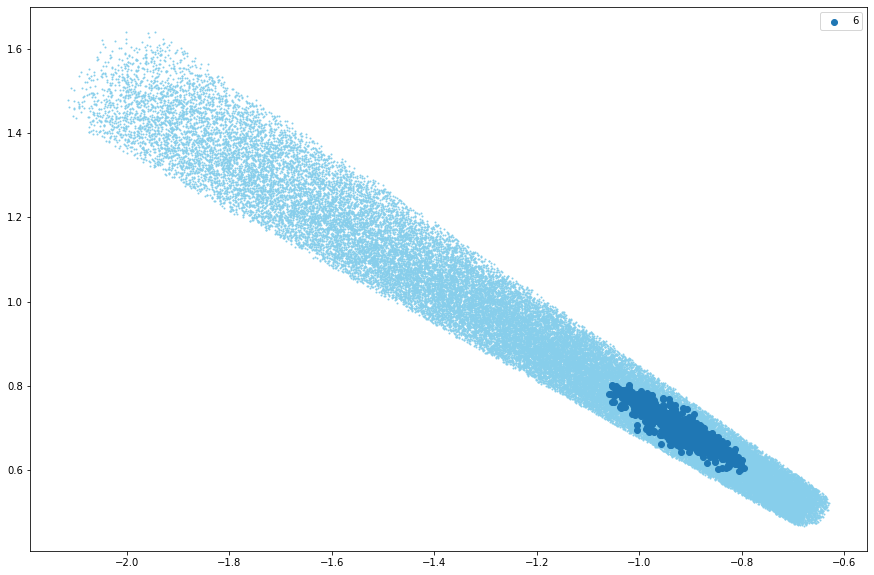

In [628]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.x, cluster_values.z, s=1, color='skyblue')
for ul in [6]:
    plt.scatter(cluster_values[sources['labels']==ul].x, cluster_values[sources['labels']==ul].z, label=ul)
plt.legend()

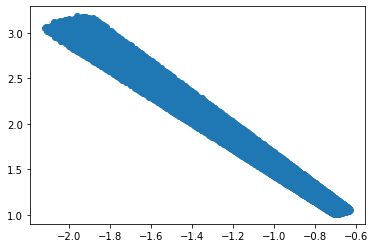

In [473]:
plt.scatter(cluster_values.x, cluster_values.y)

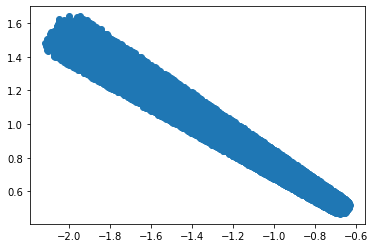

In [474]:
plt.scatter(cluster_values.x, cluster_values.z)

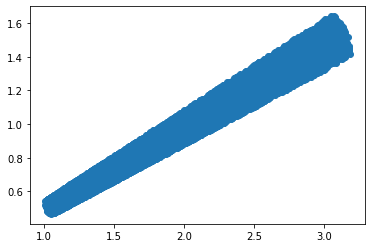

In [475]:
plt.scatter(cluster_values.y, cluster_values.z)

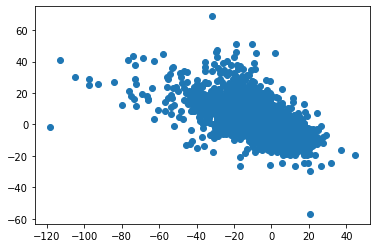

In [476]:
plt.scatter(cluster_values.u_par, cluster_values.u_per)